**Import Dataset & Packages**

In [ ]:
import pandas as pd 
import numpy as np 
from datetime import datetime
import datetime as parent_date
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install sweetviz # install the package if you haven't 
import sweetviz
import statsmodels.api as sm
from scipy.stats import chi2_contingency
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data set/Propensity to Pay_Collections Data.csv')
df_org = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Data set/cleaned_data.csv')
df_org['Amount'] = df_clean['Amount'].copy()
df_org = df_org.iloc[:,:18].copy() # for some reason, the org dataset I got has wireld column (ie: unnamed column 18)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Initial Data Cleaning & Feature Engineering for EDA

**Data Cleaning & Feature Engineering**

In [ ]:
### 1. Rearrange the order of origal dataset, so that the dataset has more consecutive logical meaning
column_order = ['Cust_Num','Customer Group','ZIPCODE','Region','City','Customer Name','Age Of Customer(Months)','Age Of Customer(Year)',
                'DocumentNo','Clrng doc.','Payment Method description','Doc. Date','Net due dt','Pstng Date','Clearing Date',
                'Amount','Payment Term','Days Overdue (Delay)']
df_org = df_org.reindex(columns=column_order)

### 2. reform the datatime columns 
# Payment Term = Net Due Date - Psting Date 
df_org['Doc. Date'] = pd.to_datetime(df_org['Doc. Date'])
df_org['Net due dt'] = pd.to_datetime(df_org['Net due dt'])
df_org['Pstng Date'] = pd.to_datetime(df_org['Pstng Date'])
# 2-1: Clearing Date = Net Due Date - Days Overdue (Delay)
holder = []
for date, delay in zip(df_org['Net due dt'],df_org['Days Overdue (Delay)']):
  result = date + parent_date.timedelta(days=delay)
  holder.append(result)

df_org['Clearing Date'] = holder

### 3. Create a new column: Is_Pay_Delay (binary variables to indicate whether this payment is delayed or not)
holder = []
for delay in df_org['Days Overdue (Delay)']:
  if delay <= 0: holder.append(0)
  else: holder.append(1)

df_org['Is_Pay_Delay'] = holder

### 4: Handle Zipcode
# The zipcode we have is psedo zipcode, so we cannot get the exact geo info (may be for privacy reason)
# So, I picked the top 6 occurance zipcode and put the rest in 'Other' Category. The occurancy as follow: 
# AX0032 - 10219
# AX0014 - 9712
# AX0028 - 7838
# AX0048 - 6367
# AX0025 - 3935
# AX0030 - 2637
# Other - 5133
for index, zip in enumerate(df_org['ZIPCODE']):
  if zip not in ['AX0032','AX0014','AX0028','AX0048','AX0025','AX0030']: 
    df_org.iloc[index,2] = 'Other'

### 5: Handle Region Code
# Same logic as zipcode
# AA125 - 10219
# AA113 - 9712
# AA121 - 8054
# AA127 - 6367
# AA120 - 3983
# AA123 - 2637
# Other - 4869
for index, zip in enumerate(df_org['Region']):
  if zip not in ['AA125','AA113','AA121','AA127','AA120','AA123']: 
    df_org.iloc[index,3] = 'Other'

### 6: Handle City Code
# Same logic as zipcode
# AA42 - 10219
# AA24 - 9712
# AA38 - 7838
# AA57 - 6367
# AA35 - 3935
# AA40 - 2637
# Other - 5133
for index, zip in enumerate(df_org['City']):
  if zip not in ['AA42','AA24','AA38','AA57','AA35','AA40']: 
    df_org.iloc[index,4] = 'Other'

### 7. Drop the following columns. Customer Name is not useful since those name are psedo names. 
# Age of the Customer in Year is overlapping with Age of Customer in Month. (One thing to note: when transfer year to month, it is not accurate)
# ie: first row: Month as 34 which is 2 Year and 10 Months but the same year reprentation is 2 year. 
# Clrng doc: not useful
to_drop = ['Customer Name','Age Of Customer(Year)','Clrng doc.']
df_org.drop(columns=to_drop,inplace=True)

### 8: Since Date column has no practical use case in prediciton and all info is in the df, let z drop them
to_drop = ['Doc. Date','Net due dt','Pstng Date','Clearing Date']
df_org.drop(columns=to_drop,inplace=True)

### 9: Create a new column indicate the total number of delay for a specific customer and aggregate into the documents level 
to_merge = df_org.groupby('Cust_Num')['Is_Pay_Delay'].agg('sum').reset_index()
Num = df_org['Cust_Num'].copy().reset_index()
Holder = Num.merge(to_merge).sort_values('index')
total_delay = Holder['Is_Pay_Delay'].values
df_org['Customer_Total_Delay'] = total_delay

### 10: Drop Customer Group Column since there are only 1 value in there as Wholeseller
df_org.drop(labels='Customer Group',axis=1,inplace=True)

### 11: Categorize the Payment Method
# ie: Put Regulatory, Regulatory 1, Regulatory 2 into Regulatory type
# Since Direct Payment is mojority, so turn this column into 2 level binary value
df_org.loc[df_org['Payment Method description'].isin(['Direct Debits 2','Direct Debits 1']),'Payment Method description'] = 'Direct Debits'
df_org.loc[df_org['Payment Method description'] != 'Direct Debits','Payment Method description'] = 'Non Direct Debits'

### 12: Add target variable Over_Due_Category
# 0: Not delay 
# 1: delay large than 0 and less than 30
# 2: delay large than 30 and less than 60
# 3: delay larger than 60
holder = []

for value in df_org['Days Overdue (Delay)'].values:
  if value <= 0: holder.append(0)
  elif (value > 0) & (value <= 30): holder.append(1)
  elif (value > 30) & (value <= 60): holder.append(2)
  else: holder.append(3)

df_org['Over_Due_Category'] = holder

### 13. Drop Variables
to_drop=['Days Overdue (Delay)','Is_Pay_Delay']
df_org.drop(columns=to_drop,inplace=True)

### 12. Quick Descriptive Analysis for the cleaned dataframe
sweetviz.analyze(df_org).show_html()

### 13. Save the dataset
df_org.to_csv('/content/drive/My Drive/Colab Notebooks/Data set/cleaned_data.csv',index=False)

In [ ]:
df_org.head()

,Cust_Num,ZIPCODE,Region,City,Age Of Customer(Months),DocumentNo,Payment Method description,Amount,Payment Term,Customer_Total_Delay,Over_Due_Category
0,5039221123,Other,Other,Other,34.0,91225033129,Direct Debits,23672.43,45,15,1
1,5039221123,Other,Other,Other,34.0,91225033130,Direct Debits,3689.47,45,15,1
2,5039221123,Other,Other,Other,34.0,91225033131,Direct Debits,366.84,44,15,1
3,5039221116,Other,Other,Other,65.0,91225033132,Direct Debits,259.84,5,74,1
4,5039221094,AX0014,AA113,AA24,155.0,91225033133,Direct Debits,176.21,5,5091,0


In [ ]:
df_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45841 entries, 0 to 45840
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Cust_Num                    45841 non-null  int64  
 1   ZIPCODE                     45841 non-null  object 
 2   Region                      45841 non-null  object 
 3   City                        45841 non-null  object 
 4   Age Of Customer(Months)     45841 non-null  float64
 5   DocumentNo                  45841 non-null  int64  
 6   Payment Method description  45841 non-null  object 
 7   Amount                      45839 non-null  float64
 8   Payment Term                45841 non-null  int64  
 9   Customer_Total_Delay        45841 non-null  int64  
 10  Over_Due_Category           45841 non-null  int64  
dtypes: float64(2), int64(5), object(4)
memory usage: 3.8+ MB


# Second Exploritaty Data Analysis

**Exploritary Analysis**

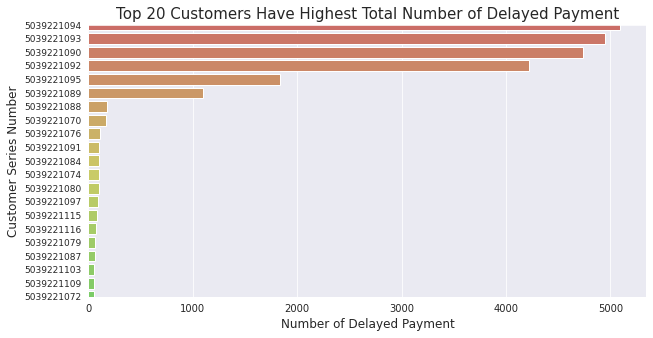

In [ ]:
df_org['Cust_Num'] = df_org['Cust_Num'].astype('string')
df_temp = df_org.sort_values(by='Customer_Total_Delay',ascending=False).copy()

fig, ax1 = plt.subplots(figsize=(10,5))
sns.set_style('darkgrid')
sns.barplot(x='Customer_Total_Delay',y='Cust_Num',data=df_temp,palette='hls',ax=ax1)
ax1.set_ylim(bottom=20,top=0)
plt.yticks(fontsize=9)

plt.title('Top 20 Customers Have Highest Total Number of Delayed Payment',fontsize=15)
plt.xlabel('Number of Delayed Payment',fontsize=12)
plt.ylabel('Customer Series Number',fontsize=12)

plt.savefig('/content/drive/My Drive/Colab Notebooks/Data set/Customer_Delay.png')
plt.show()

**ECDF Chart**

Customer Business Life Circle Chart (upper left conor): 
> - 15% (0.15) of the customer have been doing business with us less than 140 months. 
> - 100% of the customer in this dataset have beening doing business with us less than 160 months. 

Customer Total Number of Delayed Payment Chart (upper right conor): 
> - 25% of the customers has Total number of delayed payment less than 2000 invoices. 
> - 80% of the customers has total number of delayed payment less than 5000 invoices. 

Invoice Payment Term by Day Chart (Lower left conor): 
> - 83% of the invoices has invoice payment term less than 15 days. 
> - 17% of the invoices has invoice payment term between 50 and 150 days. 

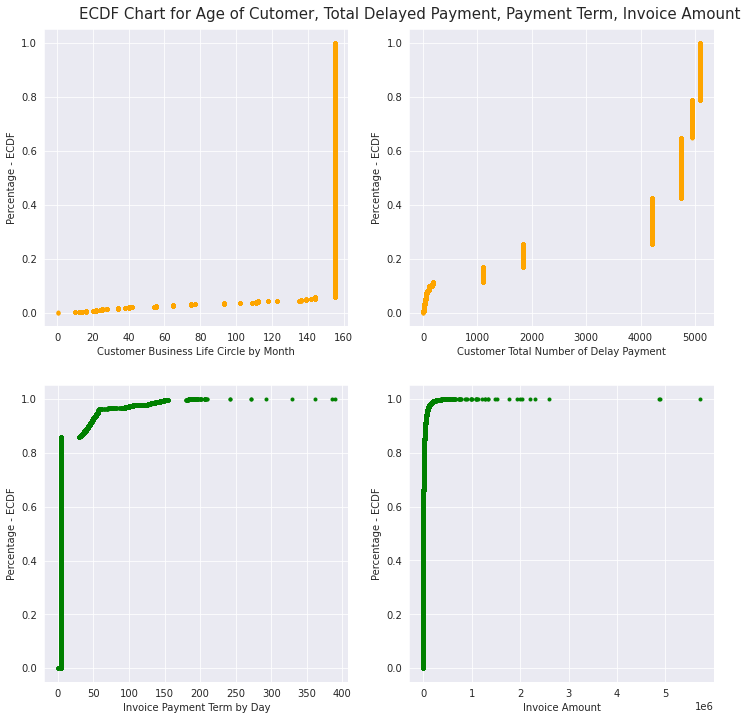

In [ ]:
x_age = np.sort(df_org['Age Of Customer(Months)'])
x_amount = np.sort(df_org['Amount'])
x_term = np.sort(df_org['Payment Term'])
x_total_delay = np.sort(df_org['Customer_Total_Delay'])

y_age = np.arange(1,len(x_age)+1) / len(x_age)
y_amount = np.arange(1,len(x_amount)+1) / len(x_amount)
y_term = np.arange(1,len(x_term)+1) / len(x_term)
y_total_delay = np.arange(1,len(x_total_delay)+1) / len(x_total_delay)

fig,[(ax1,ax2),(ax3,ax4)] = plt.subplots(nrows=2,ncols=2,figsize=(12,12))
ax1.plot(x_age,y_age,marker='.',linestyle='none',color='orange')
ax4.plot(x_amount,y_amount,marker='.',linestyle='none',color='green')
ax3.plot(x_term,y_term,marker='.',linestyle='none',color='green')
ax2.plot(x_total_delay,y_total_delay,marker='.',linestyle='none',color='orange')

ax1.set_xlabel('Customer Business Life Circle by Month')
ax1.set_ylabel('Percentage - ECDF')

ax4.set_xlabel('Invoice Amount')
ax4.set_ylabel('Percentage - ECDF')

ax3.set_xlabel('Invoice Payment Term by Day')
ax3.set_ylabel('Percentage - ECDF')

ax2.set_xlabel('Customer Total Number of Delay Payment')
ax2.set_ylabel('Percentage - ECDF')

plt.title('ECDF Chart for Age of Cutomer, Total Delayed Payment, Payment Term, Invoice Amount',y=2.215,x=0,fontsize=15)

plt.savefig('/content/drive/My Drive/Colab Notebooks/Data set/ECDF.png')
plt.show()

**Pie Chart for Geographic Region & Payment Method - Very Interesting**

> - Among all six Top Occurancy Zipcode / Region / City, Non of them are using methods other than Direct Payment. 

> - It seems like payment methods such as Wire and Regulatory payments are not popular among our client base. 

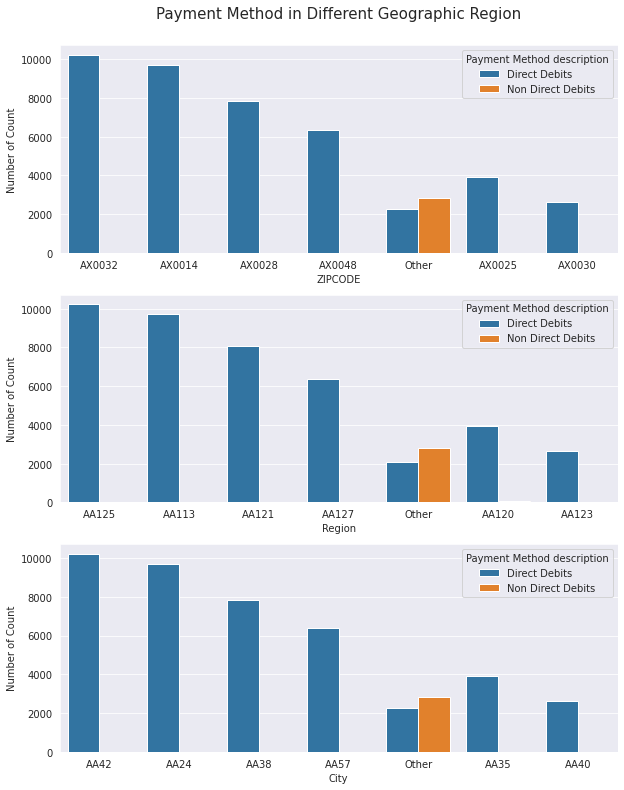

In [ ]:
fig, [ax1,ax2,ax3] = plt.subplots(nrows=3,ncols=1,figsize=(10,13))
sns.countplot(x='ZIPCODE',data=df_org,hue='Payment Method description',order=df_org['ZIPCODE'].value_counts().index,ax=ax1)
sns.countplot(x='Region',data=df_org,hue='Payment Method description',order=df_org['Region'].value_counts().index,ax=ax2)
sns.countplot(x='City',data=df_org,hue='Payment Method description',order=df_org['City'].value_counts().index,ax=ax3)

plt.title('Payment Method in Different Geographic Region',y=3.5,fontsize=15)
plt.ylabel('Number of Count')
ax1.set_ylabel('Number of Count')
ax2.set_ylabel('Number of Count')

plt.savefig('/content/drive/My Drive/Colab Notebooks/Data set/Geo_Payment_Type.png')
plt.show()

**Relationship Between Payment Amount & Customer Business Life Circle**

> - It seems like the longer the customer doing business with company, the more likely they will granted higher loan Amount. 
> - It is interesting that for some large loan amount, the repayment method are non direct Debits such as wire transfer / regulatory payment. 

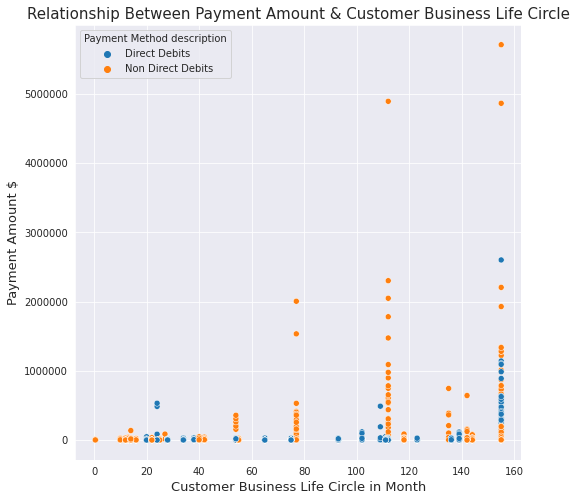

In [ ]:
fig,ax1 = plt.subplots(figsize=(8,8))
sns.scatterplot(x='Age Of Customer(Months)',y='Amount',data=df_org,hue='Payment Method description')
ax1.ticklabel_format(style='plain')
plt.title('Relationship Between Payment Amount & Customer Business Life Circle',fontsize=15)
plt.xlabel('Customer Business Life Circle in Month',fontsize=13)
plt.ylabel('Payment Amount $',fontsize=13)

plt.savefig('/content/drive/My Drive/Colab Notebooks/Data set/Payment_Life_Circle.png')
plt.show()

**Number of Total Delay for Each Customer & Payment Amount**
> - It seems like for the more customer didn't pay the repayment on time, the less the loan they will granted.
> - It interesting that those customer who has higher number of delayed payment, all of them are using Direct Payment. For those who not using the direct payment such as wire transfer, they did not have the late due payment. May be due to the wire transfer is more accessable than direct payment. 

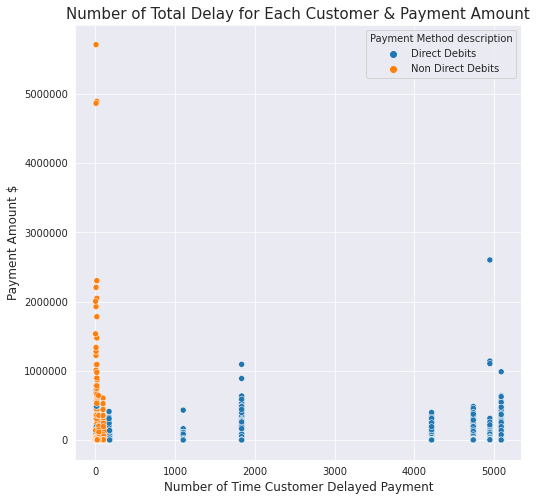

In [ ]:
fig,ax1 = plt.subplots(figsize=(8,8))
sns.scatterplot(x='Customer_Total_Delay',y='Amount',data=df_org,hue='Payment Method description',ax=ax1)
ax1.ticklabel_format(style='plain')
plt.title('Number of Total Delay for Each Customer & Payment Amount',fontsize=15)
plt.xlabel('Number of Time Customer Delayed Payment',fontsize=12)
plt.ylabel('Payment Amount $',fontsize=12)
plt.show()

# Featuere Selection & Second Data Cleaning for Modeling

In [ ]:
### 1: Encode the payment method
zipcode_dict = {'Other':0,'AX0032':1,'AX0014':2,'AX0028':3,'AX0048':4,'AX0025':5,'AX0030':6}
region_dict = {'Other':0,'AA125':1,'AA113':2,'AA121':3,'AA127':4,'AA120':5,'AA123':6}
city_dict = {'Other':0,'AA42':1,'AA24':2,'AA38':3,'AA57':4,'AA35':5,'AA40':6}
payment_dict = {'Direct Debits':1,'Non Direct Debits':0}

df_org['Payment Method description'] = df_org['Payment Method description'].map(payment_dict)
df_org['ZIPCODE'] = df_org['ZIPCODE'].map(zipcode_dict)
df_org['Region'] = df_org['Region'].map(region_dict)
df_org['City'] = df_org['City'].map(city_dict)

### 2: Get the is due day weekend column
df_org['Net_Due_Date'] = pd.to_datetime(df_org['Net_Due_Date'])
df_org['Invoice_due_weekend'] = df_org['Net_Due_Date'].dt.dayofweek
df_org['Invoice_due_weekend'] = df_org['Invoice_due_weekend'] + 1 
df_org.loc[df_org['Invoice_due_weekend'].isin([1,2,3,4,5]),'Invoice_due_weekend'] = 'Weekday'
df_org.loc[df_org['Invoice_due_weekend'].isin([6,7]),'Invoice_due_weekend'] = 'Weekend'
df_org['Invoice_due_weekend'] = df_org['Invoice_due_weekend'].map({'Weekday':0,'Weekend':1})

### 3: Drop the due day column
df_org.drop(columns='Net_Due_Date',inplace=True)

### 4: Continouos variables normalization
df_org['Age Of Customer(Months)'] = (df_org['Age Of Customer(Months)'] - df_org['Age Of Customer(Months)'].mean()) / df_org['Age Of Customer(Months)'].std()
df_org['Amount'] = (df_org['Amount'] - df_org['Amount'].mean()) / df_org['Amount'].std()
df_org['Payment Term'] = (df_org['Payment Term'] - df_org['Payment Term'].mean()) / df_org['Payment Term'].std()
df_org['Customer_Total_Delay'] = (df_org['Customer_Total_Delay'] - df_org['Customer_Total_Delay'].mean()) / df_org['Customer_Total_Delay'].std()

### 5: Re-order columns 
col_order = ['Cust_Num','DocumentNo','ZIPCODE','Region','City','Payment Method description','Invoice_due_weekend',
             'Age Of Customer(Months)','Amount','Payment Term','Customer_Total_Delay','Over_Due_Category']

df_org = df_org.reindex(columns=col_order)

### 5-1: Remove 2 missing value from amount 
df_org.drop(index=[45839,45840],inplace=True)

### 6: Save the modeling data set
df_org.to_csv('/content/drive/My Drive/Colab Notebooks/Data set/modeling_data.csv',index=False)

### 7: Get the Modeling dataset 
model_data = df_org.drop(['Cust_Num','DocumentNo'],axis=1).copy()

In [ ]:
### 4: Chi_Squared Test for categorical variables 
# H0: two variables are independent
def chi_square_test(x_var):
  table = pd.crosstab(df_org['Over_Due_Category'],df_org[x_var])
  chi, pvalue, dof, ex = chi2_contingency(table.values)
  if pvalue > 0.05: print(x_var,'is independent and not include in model')
  else: print(x_var,'is related with y var and should include in model')

for col in ['ZIPCODE','Region','City','Payment Method description','Invoice_due_weekend']: 
  chi_square_test(col)

ZIPCODE is related with y var and should include in model
Region is related with y var and should include in model
City is related with y var and should include in model
Payment Method description is related with y var and should include in model
Invoice_due_weekend is related with y var and should include in model


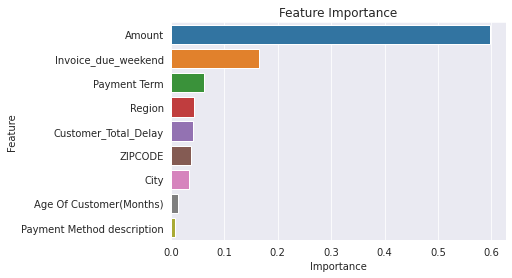

In [ ]:
# 5: Feature Selection by Decision Tree 
# Since Customer_Total_Delay & Payment Term are highly correlated, and Payment Term is more important, so remove Customer_Total_Delay
# Since the Zipcode, Region, and City essentially indicate a very similar object, so I only keep the zipcode
# Payment Term & Customer_Total_Delay is strongly negative correlated
model_data.loc[:,['Age Of Customer(Months)','Amount','Payment Term','Customer_Total_Delay']].corr()

classifer = ExtraTreesClassifier()
result = classifer.fit(indenpend_var,target_var)

result_df = pd.DataFrame({'Feature':indenpend_var.columns.values,'Importance':result.feature_importances_})
result_df.sort_values('Importance',ascending=False,inplace=True)

sns.barplot(x='Importance',y='Feature',data=result_df)
plt.title('Feature Importance')
plt.show()

# 6: Drop those columns mentioned above
model_data.drop(['Region','City','Customer_Total_Delay'],axis=1,inplace=True)

**Multinomial Logistic Regresion Result**
> - [How to Explain the result](https://https://stats.idre.ucla.edu/stata/output/multinomial-logistic-regression-2/)

> - for Continouos variables (`Age Of Customer(Months)`, `Amount`,`Payment Term`), explain those as 1 std increase becasue I standarlized the data before regression. 

1.   **std for Age of customer**: 21.1
2.   **std for Amount**: 68777.0
3.   **std for Payment Term**: 26.3


In [ ]:
target_var = model_data['Over_Due_Category'].copy()
indenpend_var = model_data.drop(['Over_Due_Category','Region','City','Customer_Total_Delay'],axis=1).copy()
mod = sm.MNLogit(target_var,indenpend_var).fit()
print(mod.summary())

                          MNLogit Regression Results                          
Dep. Variable:      Over_Due_Category   No. Observations:                45839
Model:                        MNLogit   Df Residuals:                    45821
Method:                           MLE   Df Model:                           15
Date:                Thu, 12 Nov 2020   Pseudo R-squ.:                 0.08651
Time:                        04:47:07   Log-Likelihood:                -32597.
converged:                       True   LL-Null:                       -35684.
Covariance Type:            nonrobust   LLR p-value:                     0.000
       Over_Due_Category=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
ZIPCODE                        0.0678      0.007     10.092      0.000       0.055       0.081
Payment Method description    -0.6863      0.023    -29.747      0.000      -0.731 

# Modeling

In [ ]:
### Split the Train Test datasets
target_var = model_data['Over_Due_Category'].copy()
indenpend_var = model_data.drop('Over_Due_Category',axis=1).copy()
x_train,x_test,y_train,y_test = train_test_split(indenpend_var,target_var,test_size=0.2,random_state=666)

**Logistic Regression Multinominal**

In [ ]:
parameter_dict_logistic ={
    'penalty':['l1','l2','elasticnet'],
    'C':[0.1,0.3,0.5,0.7,0.9,1.0],
    'solver':['newton-cg','sag','saga','lbfgs'],
}

logistic_model = LogisticRegression()

grid_logistic = GridSearchCV(estimator=logistic_model,param_grid=parameter_dict_logistic,scoring='roc_auc_ovr_weighted',cv=5,n_jobs=-1)

grid_logistic.fit(x_train,y_train)

print(grid_logistic.best_params_)
print('the best roc_auc_weighted score is', grid_logistic.best_score_)

{'C': 0.7, 'penalty': 'l2', 'solver': 'lbfgs'}
the best roc_auc_weighted score is 0.706559351107521


**KNN Classifier**

In [ ]:
parameter_KNN = {
    'n_neighbors':[5,10,15,20,25,30,35,40,45,50,55,60],
    'weights':['uniform','distance'],
    'p':[1,2]
}

KNN_Classifier = KNeighborsClassifier()

grid_KNN = GridSearchCV(estimator=KNN_Classifier,param_grid=parameter_KNN,scoring='roc_auc_ovr_weighted',cv=5,n_jobs=-1)

grid_KNN.fit(x_train,y_train)

print(grid_KNN.best_params_)
print('the best roc_auc_weighted score is', grid_KNN.best_score_)

{'n_neighbors': 60, 'p': 1, 'weights': 'uniform'}
the best roc_auc_weighted score is 0.801720095159556


**Decision Tree**

In [ ]:
parameter_tree = {
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_depth':[None,10,20,30,40,50,60],
    'min_samples_split':[2,4,6,8,10,20,30]
}

Tree_Classifier = DecisionTreeClassifier()

grid_tree = GridSearchCV(estimator=Tree_Classifier,param_grid=parameter_tree,scoring='roc_auc_ovr_weighted',cv=5,n_jobs=-1)

grid_tree.fit(x_train,y_train)

print(grid_tree.best_params_)
print('the best roc_auc_weighted score is', grid_tree.best_score_)

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 30, 'splitter': 'random'}
the best roc_auc_weighted score is 0.8007284133645829


**AUC_ROC Score**

> - If you wanna plot the auc roc curve, it gonna be one for each level each model. I think score is good enough. 

In [ ]:
classifier = [
              LogisticRegression(penalty='l2',solver='lbfgs',C=0.7),
              KNeighborsClassifier(n_neighbors=60,p=1,weights='uniform'),
              DecisionTreeClassifier(criterion='entropy',max_depth=10,min_samples_split=30,splitter='random'),
              GradientBoostingClassifier()
]

result_table = pd.DataFrame(columns=['classifiers', 'AUC_ROC_SCORE'])

for cls in classifier:
  model = cls.fit(x_train,y_train)
  yprob = model.predict_proba(x_test)
  roc_auc = roc_auc_score(y_test,yprob,average='weighted',multi_class='ovr')
  result_table = result_table.append({
      'classifiers':cls.__class__.__name__,
      'AUC_ROC_SCORE':roc_auc
  },ignore_index=True)


result_table.sort_values('AUC_ROC_SCORE',inplace=True,ascending=False)
result_table.reset_index(inplace=True)
result_table.drop('index',axis=1,inplace=True)

result_table

,classifiers,AUC_ROC_SCORE
0,GradientBoostingClassifier,0.800905
1,DecisionTreeClassifier,0.797677
2,KNeighborsClassifier,0.797509
3,LogisticRegression,0.704440
